#### *Run this cell to resolve import issues*

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from log_parser import parse_keyboard_log
from log_parser import parse_mouse_log
from keyboard_heatmap import KeyboardHeatmap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler


# Set to false to test non-binary classification
test_binary = False

# List of parsed logfiles
keyboard = []
mouse = []

# Read logfile paths from .routing
with open("../.routing", 'r', encoding='utf-8') as f:
    log_paths = f.read().splitlines()   # Read lines without '\n's
    for path in log_paths:
        if 'key.log' in path:
            keyboard.append(parse_keyboard_log('../' + path))
        elif 'mouse.log' in path:
            mouse.append(parse_mouse_log('../' + path))

seg_length = 120
# The quintessential target class
target = "MAR"

# Empty lists for inserting data
X_actual = []
Y_actual = []

# For confusion matrix plotting
labels = []

for k in range(len(keyboard)):
    l = None
    for i in range(int(keyboard[k].time.iloc[-1] / seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, seg_length)
        if test_binary: heatmap = heatmap.to_binary_class_label(target)
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_actual.append(heatmap.heatmap_data().ravel().tolist())
            Y_actual.append(heatmap.class_label())
        
        l = heatmap.class_label()
    labels.append(l)

#Remove duplicate labels
labels = list( dict.fromkeys(labels) )

X_train, X_test, Y_train, Y_test = train_test_split(X_actual, Y_actual, random_state=0)

Train samples: 569
Test samples: 35


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Create random forests classifier object
# n_jobs controls multithreading, -1 uses all available threads
# criterion determines how well a feature splits data, we use gini
# max_features determines the number of candidate features available for a best split
# n_estimators determines the number of trees in our forest
# oob_score determines whether or not our forest uses out of bag error
rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 

model = rfc.fit(X_train, Y_train)

# Print best score
print( f"Train score: {rfc.score(X_train, Y_train)} " + f"Test score: {rfc.score(X_test, Y_test)}")

Train score: 1.0 Test score: 1.0


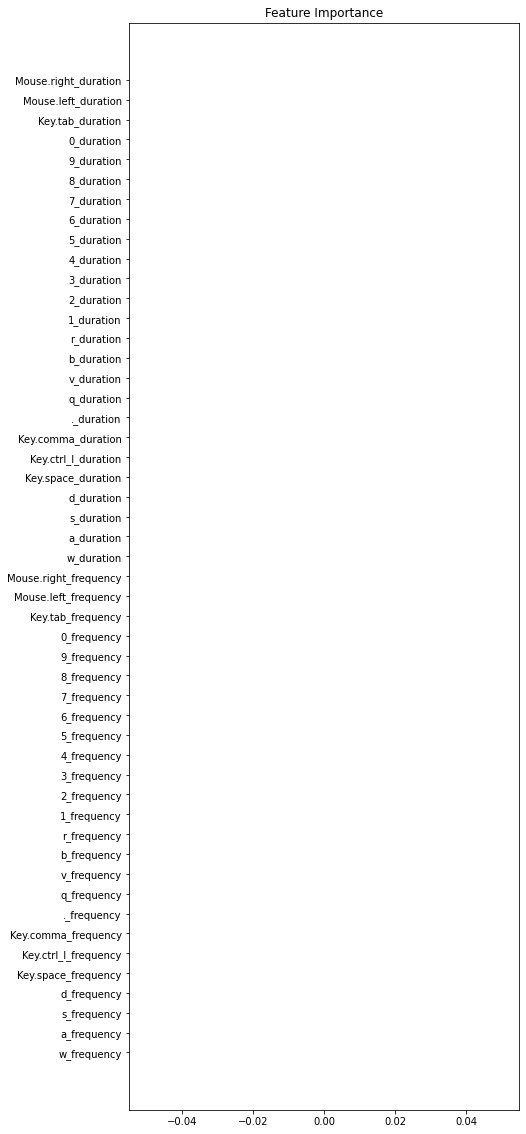

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# We want to plot the feature importance of all features to see how our classifier is splitting data
importances = model.feature_importances_
#indices = np.argsort(importances)

# Expand figure vertically
plt.figure(figsize=(7,20))

# Barplot
plt.barh(range(len(importances)), importances)
# Add feature names as y-axis labels
# replace [indices[i] for i in indices] with feature labels
plt.yticks(range(len(importances)), KeyboardHeatmap.heatmap_data_names())
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

[Text(310.0, 302.0, 'gini = 0.0\nsamples = 375\nvalue = 569.0')]

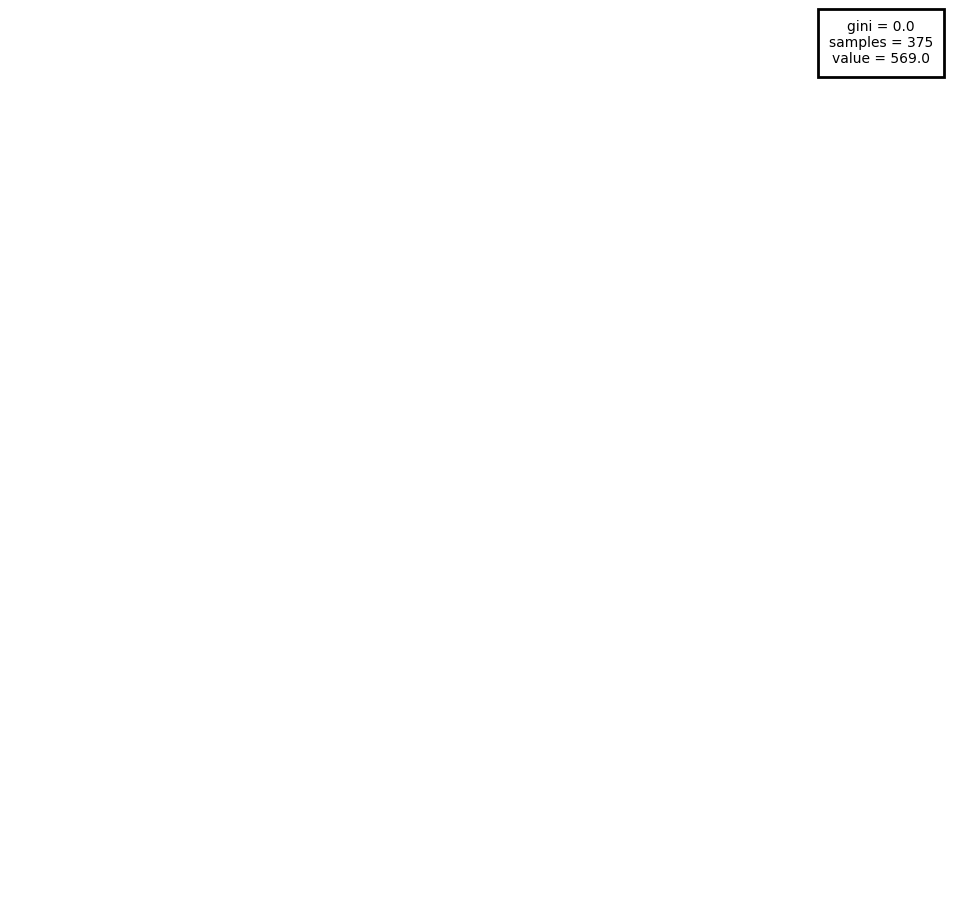

In [5]:
from sklearn import tree

# Plot one tree in our forest for fun
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rfc.estimators_[0], fontsize=5,feature_names = KeyboardHeatmap.heatmap_data_names(),filled = True)